In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

warnings.filterwarnings("ignore")

pd.set_option("mode.copy_on_write", True)

In [3]:
insurance = pd.read_csv("../01_Data/02_Processed/01_Insurance_NoMissing.csv")
insurance.sample(5)

,YEAR,SEX,RACENEW,INCFAM97ON2,HINOTCOVE,CNLUNG,SMK,Occupation_Code
389913,2017,2,100.0,32.0,2.0,1.0,1,1
378052,2017,1,100.0,20.0,1.0,2.0,1,9
110846,2005,1,100.0,30.0,1.0,1.0,1,18
153944,2008,1,100.0,20.0,2.0,1.0,2,17
246281,2012,2,200.0,32.0,1.0,1.0,2,7


In [4]:
# dropping all values where year is >= 2010
insurance = insurance[insurance["YEAR"] < 2010]

In [5]:
insurance.shape

(191658, 8)

> Drop the year variable

In [6]:
# Drop the 'YEAR' variable
insurance = insurance.drop(columns=["YEAR"])

In [7]:
insurance.head()

,SEX,RACENEW,INCFAM97ON2,HINOTCOVE,CNLUNG,SMK,Occupation_Code
0,2,100.0,30.0,1.0,1.0,1,25
1,2,100.0,96.0,1.0,1.0,2,25
2,1,100.0,10.0,2.0,1.0,1,25
3,1,100.0,10.0,1.0,1.0,1,30
4,1,100.0,20.0,1.0,1.0,2,22


## Matching

In [8]:
# Convert all columns to integer type
insurance = insurance.astype(int)

In [9]:
# Display the data types of each column in the DataFrame
print("Data types of each variable in the DataFrame:")
print(insurance.dtypes)

Data types of each variable in the DataFrame:
SEX                int64
RACENEW            int64
INCFAM97ON2        int64
HINOTCOVE          int64
CNLUNG             int64
SMK                int64
Occupation_Code    int64
dtype: object


In [10]:
# Map 1 to 1 and 2 to 0 in the "HINOTCOVE" column
insurance["HINOTCOVE"] = insurance["HINOTCOVE"].map({1: 1, 2: 0})

# Check unique values in the "HINOTCOVE" column after mapping
unique_values = insurance["HINOTCOVE"].unique()
print(unique_values)

[1 0]


In [11]:
# Map 1 to 0 and 2 to 1 in the "CNLUNG" column
insurance["CNLUNG"] = insurance["CNLUNG"].map({1: 0, 2: 1})

# Check unique values in the "CNLUNG" column after mapping
unique_values = insurance["CNLUNG"].unique()
print(unique_values)

[0 1]


In [12]:
import dame_flame

model = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
)
model.fit(
    insurance,
    treatment_column_name="HINOTCOVE",
    outcome_column_name="CNLUNG",
)
result = model.predict(insurance)

Completed iteration 0 of matching
	Number of matched groups formed in total:  1591
	Unmatched treated units:  5870 out of a total of  157251 treated units
	Unmatched control units:  105 out of a total of  34407 control units
	Number of matches made this iteration:  185683
	Number of matches made so far:  185683
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.0027701622715536798
Completed iteration 1 of matching
	Number of matched groups formed in total:  1610
	Unmatched treated units:  5835 out of a total of  157251 treated units
	Unmatched control units:  84 out of a total of  34407 control units
	Number of matches made this iteration:  56
	Number of matches made so far:  185739
	Covariates dropped so far:  frozenset({'SEX'})
	Predictive error of covariate set used to match:  0.0027701780402875683
Completed iteration 2 of matching
	Number of matched groups formed in total:  1639
	Unmatched treated units:  5518 out of a total of  157251 treated u

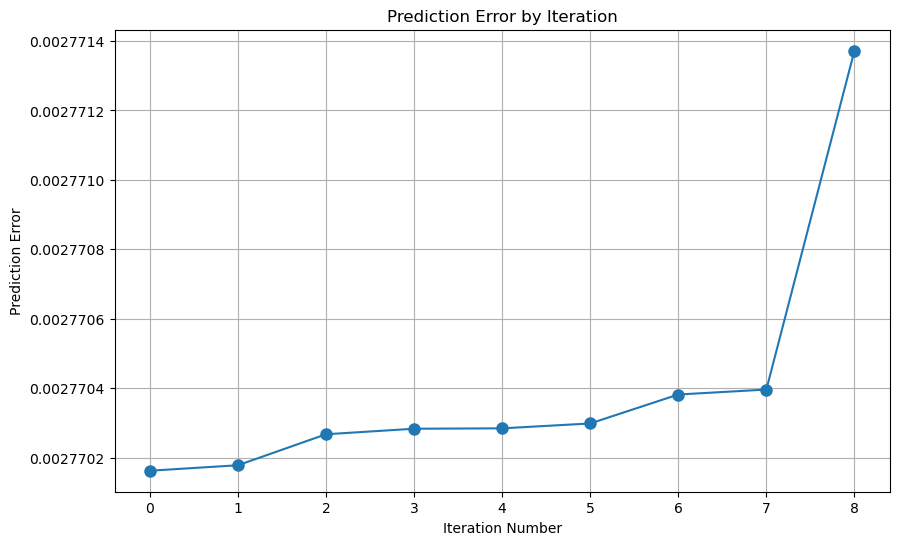

In [13]:
# Retrieve the prediction errors for each iteration
prediction_errors = model.pe_each_iter

# Plotting the prediction errors
plt.figure(figsize=(10, 6))
plt.plot(prediction_errors, marker="o", linestyle="-", markersize=8)
plt.title("Prediction Error by Iteration")
plt.xlabel("Iteration Number")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.show()

> I choose my stopping point at iteration number 0.

In [14]:
model_new = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
    early_stop_iterations=7,  # Stop after iteration 1
)
model_new.fit(
    insurance,
    treatment_column_name="HINOTCOVE",
    outcome_column_name="CNLUNG",
)
result_new = model_new.predict(insurance)

Completed iteration 0 of matching
	Number of matched groups formed in total:  1591
	Unmatched treated units:  5870 out of a total of  157251 treated units
	Unmatched control units:  105 out of a total of  34407 control units
	Number of matches made this iteration:  185683
	Number of matches made so far:  185683
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.0027701622715536798
Completed iteration 1 of matching
	Number of matched groups formed in total:  1610
	Unmatched treated units:  5835 out of a total of  157251 treated units
	Unmatched control units:  84 out of a total of  34407 control units
	Number of matches made this iteration:  56
	Number of matches made so far:  185739
	Covariates dropped so far:  frozenset({'SEX'})
	Predictive error of covariate set used to match:  0.0027701780402875683
Completed iteration 2 of matching
	Number of matched groups formed in total:  1639
	Unmatched treated units:  5518 out of a total of  157251 treated u

In [15]:
def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better

In [16]:
matched_data = get_dataframe(model_new, result_new)
matched_data.head()

,SEX,RACENEW,INCFAM97ON2,HINOTCOVE,CNLUNG,SMK,Occupation_Code,match_group,match_group_size,weights
0,2,100,30,1,0,1,25,341.0,137.0,1.000000
1,2,100,96,1,0,2,25,583.0,301.0,1.000000
2,1,100,10,0,0,1,25,95.0,651.0,0.265081
3,1,100,10,1,0,1,30,115.0,398.0,1.000000
4,1,100,20,1,0,2,22,217.0,662.0,1.000000


In [17]:
matched_data.shape

(186260, 10)

In [18]:
print(f"Checking the Columns in matched data:")
matched_data.columns

Checking the Columns in matched data:


Index(['SEX', 'RACENEW', 'INCFAM97ON2', 'HINOTCOVE', 'CNLUNG', 'SMK',
       'Occupation_Code', 'match_group', 'match_group_size', 'weights'],
      dtype='object')

In [19]:
# Model with controls and robustness check
model_with_controls = smf.wls(
    "CNLUNG ~ C(HINOTCOVE) + C(SEX) + C(RACENEW) + C(INCFAM97ON2) + C(SMK) + C(Occupation_Code)",
    data=matched_data,
    weights=matched_data["weights"],
).fit(cov_type="HC3")

In [20]:
model_with_controls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 CNLUNG   R-squared:                       0.003
Model:                            WLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     7.217
Date:                Wed, 01 May 2024   Prob (F-statistic):           4.57e-43
Time:                        05:27:23   Log-Likelihood:             3.0932e+05
No. Observations:              186260   AIC:                        -6.186e+05
Df Residuals:                  186215   BIC:                        -6.181e+05
Df Model:                          44                                         
Covariance Type:                  HC3                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0045      0.001      8.644      0.000       0.003       0.006
C(HINOTCOVE)[T.1]            0.0018      0.000      8.623      0.000       0.001       0.002
C(SEX)[T.2]                 -0.0001      0.000     -0.506      0.613      -0.001       0.000
C(RACENEW)[T.200]           -0.0006      0.000     -2.041      0.041      -0.001   -2.33e-05
C(RACENEW)[T.300]           -0.0005      0.002     -0.346      0.729      -0.004       0.003
C(RACENEW)[T.400]           -0.0006      0.001     -0.677      0.498      -0.002       0.001
C(RACENEW)[T.520]           -0.0007      0.000     -5.202      0.000      -0.001      -0.000
C(INCFAM97ON2)[T.20]        -0.0014      0.000     -4.888      0.000      -0.002      -0.001
C(INCFAM97ON2)[T.30]        -0.0021      0.000     -7.816      0.000      -0.003      -0.002
C(INCFAM97ON2)[T.31]        -0.0025      0.001     -4.620      0.000      -0.003      -0.001
C(INCFAM97ON2)[T.32]        -0.0025      0.000     -5.468      0.000      -0.003      -0.002
C(INCFAM97ON2)[T.96]        -0.0011      0.000     -2.745      0.006      -0.002      -0.000
C(SMK)[T.2]                 -0.0030      0.000    -12.913      0.000      -0.003      -0.003
C(Occupation_Code)[T.2]     -0.0002      0.001     -0.248      0.804      -0.001       0.001
C(Occupation_Code)[T.3]     -0.0006      0.001     -0.964      0.335      -0.002       0.001
C(Occupation_Code)[T.4]      0.0011      0.001      1.268      0.205      -0.001       0.003
C(Occupation_Code)[T.5]     -0.0007      0.001     -1.191      0.234      -0.002       0.000
C(Occupation_Code)[T.6]  -5.085e-05      0.001     -0.070      0.944      -0.001       0.001
C(Occupation_Code)[T.7]     -0.0004      0.001     -0.620      0.535      -0.002       0.001
C(Occupation_Code)[T.8]      0.0002      0.001      0.244      0.808      -0.001       0.002
C(Occupation_Code)[T.9]   7.859e-06      0.001      0.008      0.993      -0.002       0.002
C(Occupation_Code)[T.10]     0.0014      0.001      1.345      0.179      -0.001       0.003
C(Occupation_Code)[T.11]    -0.0016      0.001     -2.075      0.038      -0.003   -8.64e-05
C(Occupation_Code)[T.12]    -0.0007      0.001     -0.704      0.481      -0.003       0.001
C(Occupation_Code)[T.13]    -0.0009      0.001     -1.049      0.294      -0.003       0.001
C(Occupation_Code)[T.14]    -0.0020      0.001     -2.690      0.007      -0.003      -0.001
C(Occupation_Code)[T.15]    -0.0011      0.001     -1.123      0.262      -0.003       0.001
C(Occupation_Code)[T.16]    -0.0015      0.001     -1.674      0.094      -0.003       0.000
C(Occupation_Code)[T.17]    -0.0003      0.001     -0.255      0.799      -0.003       0.002
C(Occupation_Code)[T.18]    -0.0012      0.001     -1.197      0.231      -0.003       0.001
C(Occupation_C

In [21]:
# To get the coefficient for the 'HINOTCOVE' variable
insurance_coefficient_control = model_with_controls.params["HINOTCOVE"]
print(f"Coefficient for 'HINOTCOVE' with controls: {insurance_coefficient_control:.4f}")

KeyError: 'HINOTCOVE'

In [22]:
# To get the p-value for the coefficient of 'HINOTCOVE' variable
insurance_p_value_control = model_with_controls.pvalues["HINOTCOVE"]
print(f"P-value for 'HINOTCOVE' with controls: {insurance_p_value_control:.4f}")

KeyError: 'HINOTCOVE'

>- Coefficient (0.0008): The coefficient for 'HINOTCOVE' with controls (0.0008) suggests that, after controlling for other variables, there is a positive association between having insurance coverage and the outcome variable (lung cancer diagnosis status). 
>- The p-value is less than the conventional threshold of 0.05, suggesting that the estimated effect of insurance coverage on lung cancer diagnosis is statistically significant.
>- There is evidence to support the hypothesis that having insurance coverage increases the likelihood of lung cancer diagnosis, after controlling for other covariates and potential confounders.